In [5]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max
import pandas as pd
from scipy.ndimage import label
import sys

In [6]:
def remove_background(image,back_img):
    h,w = image.shape
    output = np.zeros((h,w),dtype = "uint8")
    output = np.subtract(image,back_img)
    return output

In [7]:
def apply_watershed(img):
    img_array = img.copy()
    distance = ndi.distance_transform_edt(img_array)
    markers = ndi.label(peak_local_max(distance, indices = False, labels = img_array))[0]
    ws_labels = watershed(-distance, markers, mask = img_array)
    print("[INFO] {} unique segments found".format(len(np.unique(ws_labels)) - 1))
    return ws_labels,markers

In [8]:
def make_boxes(color_img,image,labels):       
    conts=[]    
    contours=[]
    for label in np.unique(labels):
        # if the label is zero, we are examining the 'background'
        # so simply ignore it
        if label == 0:
            continue
        # otherwise, allocate memory for the label region and draw
        # it on the mask
        mask = np.zeros(gray.shape, dtype="uint8")
        mask[labels == label] = 255
        # detect contours in the mask and grab the largest one
        cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE)[-2]
        c = max(cnts, key=cv2.contourArea)
        
#         rect = cv2.minAreaRect(c)
#         box = cv2.boxPoints(rect)
#         box = np.int0(box)  
#         if cv2.contourArea(c) > 50: 
#             #cv2.drawContours(image,c,-1,(0,255,0))
#             cv2.drawContours(image,[box],-1,(128,128,128),thickness = 1)
        hull = cv2.convexHull(c)
        #cv2.drawContours(image,[hull],-1,(0,0,255),thickness = 1)
        contours.append(hull)
    for i in range(len(contours)):
        c = contours[i]

        area = cv2.contourArea(c)

        # Iterate all contours from i+1 to end of list
        for j in range(i+1, len(contours)):
            c2 = contours[j]

            area2 = cv2.contourArea(c2)

            area_sum = area + area2

            # Merge contours together
            tmp = np.vstack((c, c2))
            merged_c = cv2.convexHull(tmp)

            merged_area = cv2.contourArea(merged_c)

            # Replace contours c and c2 by the convex hull of merged c and c2, if total area is increased by no more then 10%
            if merged_area < area_sum*1.1:
                # Replace contour with merged one.
                contours[i] = merged_c
                contours[j] = merged_c
                c = merged_c
                area = merged_area
    ################################################################################


    # Draw new contours in red color
    for c in contours:
        #Ignore small contours
        if cv2.contourArea(c) > 20:
            cv2.drawContours(color_img, [c], -1, (255,0,0), 2, 1)
            cv2.drawContours(image, [c], -1, (128,128,128), 2, 1)
    return image,color_img

In [9]:
def segmentation_try_1(frame,gray):
        image = frame.copy()
        #applying min_max filtering
        kernel_erosion = np.ones((3,3),np.uint8)
        erosion = cv2.erode(gray,kernel_erosion,iterations = 1)
        kernel_dilation = np.ones((5,5), np.uint8)
        img_dilation = cv2.dilate(erosion, kernel_dilation, iterations=1)
        th = cv2.adaptiveThreshold(img_dilation,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
        frame = remove_background(th,img_dilation)
        blur = cv2.GaussianBlur(frame,(5,5),0)
        ret,th = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        frame = cv2.bitwise_not(th)
        #frame = frst(frame,2,2,0.25,0.25)
        label,markers = apply_watershed(frame)
       # print("labels",label)
       # print("markers",markers)
       # pd.DataFrame(markers).to_csv("markers.csv")
       # pd.DataFrame(label).to_csv("labels.csv")
        frame_boxes,color_img = make_boxes(image,frame,label)
        return color_img,frame_boxes

## Try the above using 1 image only

In [1]:
def create_contour_boxes(img, thresh):
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(img, contours, -1, (0,255,0), 3)
    cv2.imshow('draw contours',img)
    cv2.waitKey(0)

In [4]:
thresh_path = r'./data/DIC-C2DH-HeLa/train/masks/seq01_000.tif'
thresh = cv2.imread(thresh_path,0)

img_path = r'./data/DIC-C2DH-HeLa/train/images/seq01_000.tif'
img = cv2.imread(img_path,0)

create_contour_boxes(img, thresh)

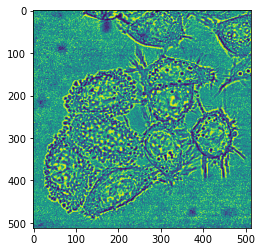

In [6]:
img_path = r'./data/DIC-C2DH-HeLa/train/images/'
img = cv2.imread(img_path,0)

clahe = cv2.createCLAHE()
img_clahe = clahe.apply(img)

plt.imshow(img_clahe)

In [16]:
cap = cv2.VideoCapture("./COMP9517_Images/PhC-C2DL-PSC/Sequence 4/t%03d.tif")
filter_size = 3
M = 0
while(1):
    ret, frame = cap.read()
    if (ret) :  
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        cv2.imshow('original image',gray)
        
        segmentation_try_1_img,Black = segmentation_try_1(frame,gray)
        
        
        #Colored Image
        cv2.imshow('segmentation_try_1',segmentation_try_1_img)
        #Black Image
        cv2.imshow('black and white',Black)
        
        #ct.update()
        
        time.sleep(0.5)
        
    else:
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    # 'q' to quit playback
    if (cv2.waitKey(1) & 0xFF == ord('q')):
        break
        
cap.release()
cv2.destroyAllWindows()

[INFO] 189 unique segments found
[INFO] 179 unique segments found
[INFO] 188 unique segments found
[INFO] 190 unique segments found
[INFO] 191 unique segments found
[INFO] 191 unique segments found
[INFO] 187 unique segments found
[INFO] 194 unique segments found
[INFO] 192 unique segments found
[INFO] 209 unique segments found
[INFO] 186 unique segments found
[INFO] 189 unique segments found
[INFO] 194 unique segments found
[INFO] 192 unique segments found
[INFO] 190 unique segments found
[INFO] 196 unique segments found
[INFO] 189 unique segments found
[INFO] 182 unique segments found
[INFO] 188 unique segments found
[INFO] 186 unique segments found
[INFO] 192 unique segments found
[INFO] 180 unique segments found
[INFO] 203 unique segments found
[INFO] 211 unique segments found
[INFO] 216 unique segments found
[INFO] 204 unique segments found
[INFO] 192 unique segments found
[INFO] 194 unique segments found
[INFO] 219 unique segments found
[INFO] 208 unique segments found
[INFO] 196

[INFO] 881 unique segments found
[INFO] 905 unique segments found
[INFO] 910 unique segments found
[INFO] 910 unique segments found
[INFO] 914 unique segments found
[INFO] 942 unique segments found
[INFO] 946 unique segments found
[INFO] 956 unique segments found
[INFO] 923 unique segments found
[INFO] 937 unique segments found
[INFO] 948 unique segments found
[INFO] 982 unique segments found
[INFO] 965 unique segments found
[INFO] 997 unique segments found
[INFO] 1012 unique segments found
[INFO] 1007 unique segments found
[INFO] 1013 unique segments found
[INFO] 1013 unique segments found
[INFO] 1043 unique segments found
[INFO] 1011 unique segments found
[INFO] 1042 unique segments found
[INFO] 1052 unique segments found
[INFO] 1037 unique segments found
[INFO] 1033 unique segments found
[INFO] 1019 unique segments found
[INFO] 1043 unique segments found
[INFO] 1044 unique segments found
[INFO] 1035 unique segments found
[INFO] 1047 unique segments found
[INFO] 1059 unique segments 

KeyboardInterrupt: 

# DONT RUN FROM HERE.

In [ ]:
ct = CentroidTracker()

In [ ]:
# import the necessary packages
from scipy.spatial import distance as dist
from collections import OrderedDict
import numpy as np

class CentroidTracker():
    def __init__(self, maxDisappeared=50):
        # initialize the next unique object ID along with two ordered
        # dictionaries used to keep track of mapping a given object
        # ID to its centroid and number of consecutive frames it has
        # been marked as "disappeared", respectively
        self.nextObjectID = 0
        self.objects = OrderedDict()
        self.disappeared = OrderedDict()

        # store the number of maximum consecutive frames a given
        # object is allowed to be marked as "disappeared" until we
        # need to deregister the object from tracking
        self.maxDisappeared = maxDisappeared

    def register(self, centroid):
        # when registering an object we use the next available object
        # ID to store the centroid
        self.objects[self.nextObjectID] = centroid
        self.disappeared[self.nextObjectID] = 0
        self.nextObjectID += 1

    def deregister(self, objectID):
        # to deregister an object ID we delete the object ID from
        # both of our respective dictionaries
        del self.objects[objectID]
        del self.disappeared[objectID]

    def update(self, rects):
        # check to see if the list of input bounding box rectangles
        # is empty
        if len(rects) == 0:
            # loop over any existing tracked objects and mark them
            # as disappeared
            for objectID in list(self.disappeared.keys()):
                self.disappeared[objectID] += 1

                # if we have reached a maximum number of consecutive
                # frames where a given object has been marked as
                # missing, deregister it
                if self.disappeared[objectID] > self.maxDisappeared:
                    self.deregister(objectID)

            # return early as there are no centroids or tracking info
            # to update
            return self.objects

        # initialize an array of input centroids for the current frame
        inputCentroids = np.zeros((len(rects), 2), dtype="int")

        # loop over the bounding box rectangles
        for (i, (startX, startY, endX, endY)) in enumerate(rects):
            # use the bounding box coordinates to derive the centroid
            cX = int((startX + endX) / 2.0)
            cY = int((startY + endY) / 2.0)
            inputCentroids[i] = (cX, cY)

        # if we are currently not tracking any objects take the input
        # centroids and register each of them
        if len(self.objects) == 0:
            for i in range(0, len(inputCentroids)):
                self.register(inputCentroids[i])

        # otherwise, are are currently tracking objects so we need to
        # try to match the input centroids to existing object
        # centroids
        else:
            # grab the set of object IDs and corresponding centroids
            objectIDs = list(self.objects.keys())
            objectCentroids = list(self.objects.values())

            # compute the distance between each pair of object
            # centroids and input centroids, respectively -- our
            # goal will be to match an input centroid to an existing
            # object centroid
            D = dist.cdist(np.array(objectCentroids), inputCentroids)

            # in order to perform this matching we must (1) find the
            # smallest value in each row and then (2) sort the row
            # indexes based on their minimum values so that the row
            # with the smallest value as at the *front* of the index
            # list
            rows = D.min(axis=1).argsort()

            # next, we perform a similar process on the columns by
            # finding the smallest value in each column and then
            # sorting using the previously computed row index list
            cols = D.argmin(axis=1)[rows]

            # in order to determine if we need to update, register,
            # or deregister an object we need to keep track of which
            # of the rows and column indexes we have already examined
            usedRows = set()
            usedCols = set()

            # loop over the combination of the (row, column) index
            # tuples
            for (row, col) in zip(rows, cols):
                # if we have already examined either the row or
                # column value before, ignore it
                # val
                if row in usedRows or col in usedCols:
                    continue

                # otherwise, grab the object ID for the current row,
                # set its new centroid, and reset the disappeared
                # counter
                objectID = objectIDs[row]
                self.objects[objectID] = inputCentroids[col]
                self.disappeared[objectID] = 0

                # indicate that we have examined each of the row and
                # column indexes, respectively
                usedRows.add(row)
                usedCols.add(col)

            # compute both the row and column index we have NOT yet
            # examined
            unusedRows = set(range(0, D.shape[0])).difference(usedRows)
            unusedCols = set(range(0, D.shape[1])).difference(usedCols)

            # in the event that the number of object centroids is
            # equal or greater than the number of input centroids
            # we need to check and see if some of these objects have
            # potentially disappeared
            if D.shape[0] >= D.shape[1]:
                # loop over the unused row indexes
                for row in unusedRows:
                    # grab the object ID for the corresponding row
                    # index and increment the disappeared counter
                    objectID = objectIDs[row]
                    self.disappeared[objectID] += 1

                    # check to see if the number of consecutive
                    # frames the object has been marked "disappeared"
                    # for warrants deregistering the object
                    if self.disappeared[objectID] > self.maxDisappeared:
                        self.deregister(objectID)

            # otherwise, if the number of input centroids is greater
            # than the number of existing object centroids we need to
            # register each new input centroid as a trackable object
            else:
                for col in unusedCols:
                    self.register(inputCentroids[col])

        # return the set of trackable objects
        return self.objects